In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.linalg as la
import scipy.optimize as opt
import scipy.stats as st
import time

In [2]:
def ball(w,τ):
    m = len(w)
    Bw = np.zeros(m)
    for i in range(m):
        Bw[i] = np.sign(w[i])*(τ-np.max(np.array([τ-np.abs(w[i]),0])))
    return Bw 

In [3]:
def dual(λν):
    w_star = ((λν@A_tilde@DTDinvDT1)/(DT1DTDinvDT1-T))*DTDinvDT1-DTDinv@np.transpose(A_tilde)@λν
    return -0.5*la.norm(D@w_star)**2+(w_star@DT1)**2/(2*T)-λν@A_tilde@w_star+λν@b_tilde

In [4]:
def grad_dual(λν,δ=1e-4):
    N = len(λν)
    grad = np.zeros(N)
    for i in range(N):
        e_L = np.zeros(N)
        e_R = np.zeros(N)
        e_L[i] = -δ
        e_R[i] = δ
        grad[i] = (dual(λν+e_R)-dual(λν+e_L))/(2*δ)
    return grad

In [5]:
def part(w):
    m = len(w)
    Pw = np.zeros(m)
    for i in range(m):
        Pw[i] = np.max(np.array([w[i],0]))
    return Pw

In [6]:
np.random.seed(432)

data_str = "oilgas-10y"
S_df = pd.read_csv("C:\\Users\\zhubr\\OneDrive\\Desktop\\STAT 432\\data-"+data_str+".csv")
S_df = S_df.drop(columns=['Date'])
S_df = S_df.iloc[::-1].astype('float')
S_df.head()
S = S_df.to_numpy()



In [7]:
S_in = S[1800:2200,:]
S_out = S[2200:2300,:]

T = S_in.shape[0]
N = S_in.shape[1]

ϕ = np.array([0.6,-0.1,0.3])
p = len(ϕ)

D = np.zeros((T-p,N))
for t in range(p,T):
    for i in range(N):
        D[t-p,i] = S[t,i]-ϕ@np.flip(S[(t-p):t,i])
        
T = D.shape[0]

A = np.array([np.ones(N),-np.ones(N)])
b = np.array([1,-1])
K = len(b)

A_tilde = np.vstack((A,np.eye(N)))
b_tilde = np.hstack((b,np.zeros(N)))

DTD = np.transpose(D)@D
DTDinv = la.inv(DTD)
DT1 = np.transpose(D)@np.ones(T)
DTDinvDT1 = DTDinv@DT1
DT1DTDinvDT1 = DT1@DTDinvDT1
ADTDinvAT = A_tilde@DTDinv@np.transpose(A_tilde)
ADTDinvDT1 = A_tilde@DTDinvDT1
Z = DT1DTDinvDT1-T

def mvpo(S,τ,NIT,η):
    
    time_0 = time.time()
    
    μ_curr = np.zeros(K+N)
    D_hist = np.zeros(NIT)
    μ_hist = np.zeros((NIT,K+N))
    for t in range(NIT):
        w_star_curr = (μ_curr@ADTDinvDT1/Z)*DTDinvDT1-DTDinv@np.transpose(A_tilde)@μ_curr
        g1_curr = (DT1DTDinvDT1*μ_curr@ADTDinvDT1/Z)*(ADTDinvDT1/Z)-(2*μ_curr@ADTDinvDT1/Z)*ADTDinvDT1+ADTDinvAT@μ_curr
        g2_curr = (1/T)*(DT1DTDinvDT1*μ_curr@ADTDinvDT1/Z)*(DT1DTDinvDT1*ADTDinvDT1/Z)+(1/T)*μ_curr@ADTDinvDT1*ADTDinvDT1-(2/T)*(DT1DTDinvDT1*μ_curr@ADTDinvDT1/Z)*ADTDinvDT1
        g3_curr = (2*μ_curr@ADTDinvDT1/Z)*ADTDinvDT1-2*ADTDinvAT@μ_curr
        g4_curr = b_tilde
        g_curr = -g1_curr+g2_curr-g3_curr+g4_curr
        μ_next = μ_curr-η*g_curr
        λ_next = part(μ_next[:K])
        ν_next = ball(μ_next[K:],τ)
        μ_next = np.hstack((λ_next,ν_next))
        D_hist[t] = dual(μ_next)
        μ_hist[t,:] = μ_next
        μ_curr = μ_next

    time_1 = time.time()
    print(np.round(time_1-time_0,3),"seconds")

    plt.plot(D_hist)
    plt.grid()
    plt.show()
    
    return w_star_curr

0.337 seconds


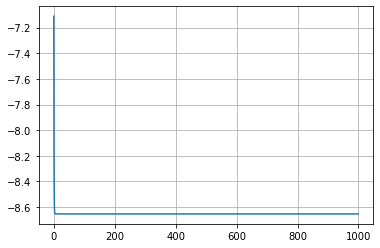

0.281 seconds


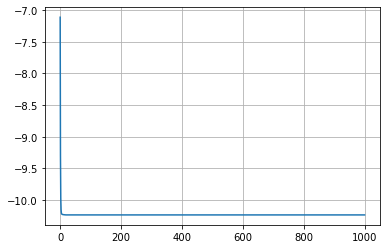

0.291 seconds


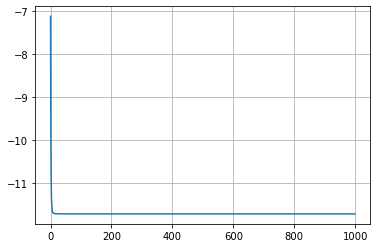

0.29 seconds


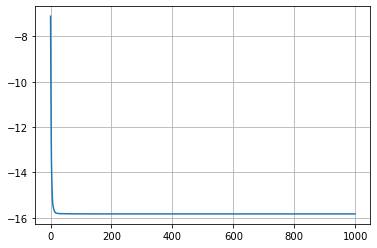

In [8]:
w_0 = mvpo(S_in,0,1000,1e1)
w_I = mvpo(S_in,1,1000,1e1)
w_V = mvpo(S_in,2,1000,1e1)
w_X = mvpo(S_in,5,1000,1e1)

In [9]:
w_0

array([-0.05143674, -0.09248103, -0.02842574, -0.03457745,  0.00960268,
        0.03807974, -0.05523506,  0.04602027,  0.35600853, -0.00038343,
        0.00677487,  0.26571202,  0.07756207,  0.08700304,  0.01409301,
        0.33117323, -0.03783995, -0.01221277,  0.09879242, -0.01822972])

In [10]:
w_I

array([-4.43016784e-02, -9.79338080e-02, -1.70290949e-02, -3.50648679e-02,
        1.55604696e-15,  2.77771158e-02, -2.72487296e-02,  3.88057243e-02,
        3.54159104e-01,  2.64718802e-15,  5.25077534e-03,  2.56874070e-01,
        8.04725868e-02,  8.28580027e-02,  1.56654659e-02,  3.14729772e-01,
       -3.50434861e-02, -2.86766733e-03,  8.28967147e-02,  5.62050406e-16])

In [11]:
w_V

array([-3.42890674e-02, -1.02114308e-01, -1.18991336e-02, -3.43631327e-02,
        8.58688121e-16,  1.81684113e-02, -1.07621296e-03,  3.85075579e-02,
        3.44337982e-01,  2.65412692e-15,  3.05950872e-03,  2.56573156e-01,
        7.81300325e-02,  8.13255374e-02,  1.40480587e-02,  3.13127010e-01,
       -3.12916019e-02, -4.82253126e-15,  6.77562023e-02,  1.47104551e-15])

In [12]:
w_X

array([-6.96306415e-03, -1.05180924e-01,  1.13797860e-15, -3.15434896e-02,
        1.39124823e-15,  7.54434650e-04,  1.67921232e-15,  3.61488510e-02,
        3.40774984e-01,  4.27435864e-15,  3.84909309e-04,  2.60370296e-01,
        8.25920561e-02,  7.93484410e-02,  8.26866730e-03,  3.15391451e-01,
       -1.97162896e-02, -5.82867088e-15,  3.93696772e-02,  5.59968738e-15])

In [13]:
P_0 = np.zeros(np.shape(S_out)[0])
P_I = np.zeros(np.shape(S_out)[0])
P_V = np.zeros(np.shape(S_out)[0])
P_X = np.zeros(np.shape(S_out)[0])
for t in range(len(P_0)):
    P_0[t] = w_0@S_out[t,:]
    P_I[t] = w_I@S_out[t,:]
    P_V[t] = w_V@S_out[t,:]
    P_X[t] = w_X@S_out[t,:]

In [14]:
P_0 = np.zeros(np.shape(S_in)[0])
P_I = np.zeros(np.shape(S_in)[0])
P_V = np.zeros(np.shape(S_in)[0])
P_X = np.zeros(np.shape(S_in)[0])
for t in range(len(P_0)):
    P_0[t] = w_0@S_in[t,:]
    P_I[t] = w_I@S_in[t,:]
    P_V[t] = w_V@S_in[t,:]
    P_X[t] = w_X@S_in[t,:]

In [15]:
print(np.mean(P_0))
print(np.mean(P_I))
print(np.mean(P_V))
print(np.mean(P_X))

20.709317182355313
21.05061672984707
21.518341973084734
22.205102516327585


In [16]:
def cross(P,μ):
    T = len(P)
    χ = 0
    for t in range(T-1):
        if (P[t]-μ)*(P[t+1]-μ) < 0:
            χ += 1
    return χ

In [17]:
cross(P_0,np.mean(P_0))

8

In [18]:
cross(P_I,np.mean(P_I))

22

In [19]:
cross(P_V,np.mean(P_V))

26

In [20]:
cross(P_X,np.mean(P_X))

22